# makemore: part 2

In [836]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [837]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [838]:
len(words)

32033

In [839]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [840]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(f"".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [841]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [842]:
# build the dataset


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [843]:
d = 2
C = torch.randn((27, d))

In [844]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [845]:
W1 = torch.randn((block_size * d, 100))
b1 = torch.randn(100)

In [846]:
h = torch.tanh(emb.view((-1, block_size * d)) @ W1 + b1)
h

tensor([[-0.2285,  0.7995, -0.6977,  ..., -0.6275,  0.9296,  0.2690],
        [-0.9459,  0.9997, -0.7282,  ..., -0.8754,  0.7822,  0.9835],
        [ 0.7513,  0.4331,  0.8514,  ..., -0.8710,  0.3745,  0.9596],
        ...,
        [ 0.9732, -1.0000, -0.9939,  ..., -0.8932,  0.9999, -1.0000],
        [-1.0000,  0.8942,  0.8977,  ...,  0.7485, -0.9763, -0.9997],
        [ 0.9922,  0.9979,  0.6997,  ..., -0.8528, -0.9991,  1.0000]])

In [847]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [848]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [849]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(14.1751)

In [850]:
# ---------------------------- Now made more respectable ----------------------------

In [851]:
g = torch.Generator().manual_seed(2147483647)
d = 10
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((block_size * d, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [852]:
sum(p.nelement() for p in parameters)  # number of parameters in total

11897

In [853]:
for p in parameters:
    p.requires_grad = True

In [854]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs

In [855]:
from tqdm.notebook import tqdm

lri = []
lossi = []
stepi = []

In [856]:
for i in tqdm(range(200000)):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (128,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (32, 3, 2)
    h = torch.tanh(emb.view((-1, block_size * d)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    # counts = logits.exp()  # (32, 27)
    # probs = counts / counts.sum(1, keepdim=True)  # (32, 27)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

  0%|          | 0/200000 [00:00<?, ?it/s]

2.0555458068847656


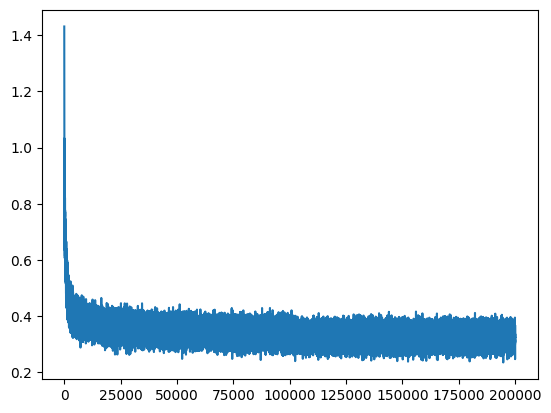

In [857]:
plt.plot(stepi, lossi)

In [858]:
# plt.plot(lri, lossi)

In [859]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view((-1, block_size * d)) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1229, grad_fn=<NllLossBackward0>)

In [860]:
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view((-1, block_size * d)) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1609, grad_fn=<NllLossBackward0>)

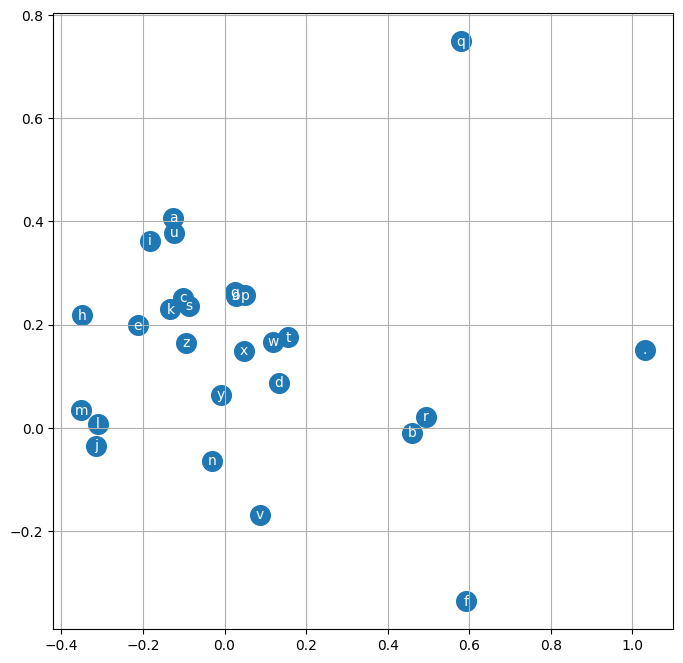

In [861]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [862]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view((1, -1)) @ W1 + b1)  # (1, 100)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

mora.
kayah.
see.
med.
rylloren.
ruthadraeg.
aderedielin.
shy.
jen.
edelieananaraelyn.
malaia.
noshubergahimies.
kindreelynnx.
teromi.
brence.
ryyah.
fael.
yuma.
myskolan.
halina.
